In [1]:
import sys
sys.path.append('../utils')
from nd_tools import (scale_img,
                      get_superpixel_means_as_features,
                      get_array_from_features,
                      filter_binary_array_by_min_size)

from rio_tools import polygonize_array_to_shapefile
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from skimage.restoration import denoise_tv_bregman
import pandas
import pandas as pd
import seaborn as sns

The goal of this notebook is to demonstrate how to utilize the same open source tools discussed in the previous notebooks to detect forest loss. Here, we identify forest loss according to decrease in HV backscatter as done globally [here](https://www.sciencedirect.com/science/article/pii/S0034425714001527) - JAXA uses proprietary eCognition software for their segmentation but we will use skimage, which is open source.

We downloaded the data from the ASF [search tool](https://search.asf.alaska.edu) over the Thai city [Ko Panyi](https://en.wikipedia.org/wiki/Ko_Panyi). The link to the original ALOS-1 data tiles can be downloaded here: [first image](https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_07915_FBD_F0150_RT2.zip) and [second image](https://datapool.asf.alaska.edu/RTC_LOW_RES/A3/AP_12612_FBD_F0150_RT2.zip) (you will have to be signed in Earth Data to download).  We selected these two images over the geographic area so that:

+ The images are RTC-ed - no dependence on incidence angle.
+ The images are low resolution - permits quick exploratory analysis - high resolution images are available, but require more disk space and more processing time.
+ The images are acquired during summer months for fair year-to-year comparison and when there is little rain which can impact backscatter.
+ The images are dual polarization (HH and HV) so we can construct the RGB as done previously.
+ There are nodata/nan areas when you download the data. For this tutorial, we fill nodata areas using inpainting from [example](https://scikit-image.org/docs/dev/auto_examples/filters/plot_inpaint.html) from skimage.

This [tutorial](https://earthdata.nasa.gov/learn/user-resources/webinars-and-tutorials/webinar-asf-daac-16-oct-2019) demonstrates how to download data from a site of your choosing (click event recording and give permission to download the application Adobe Connect). The raw data above was cropped and acquisitions dates were appended to the file name.

# Inspecting the data

In [2]:
data_dir = Path('data')
tifs = sorted(list(data_dir.glob('*.tif')))
tifs

[PosixPath('data/AP_07915_FBD_F0150_RT2_HH_20070720.tif'),
 PosixPath('data/AP_07915_FBD_F0150_RT2_HV_20070720.tif'),
 PosixPath('data/AP_12612_FBD_F0150_RT2_HH_20080606.tif'),
 PosixPath('data/AP_12612_FBD_F0150_RT2_HV_20080606.tif')]

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
    return band

bands = list(map(open_one, tifs))

with rasterio.open(tifs[0]) as ds:
    profile = ds.profile

In [4]:
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 600, 'height': 600, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 440228.8125,
       0.0, -30.0, 937448.125), 'tiled': False, 'compress': 'packbits', 'interleave': 'band'}

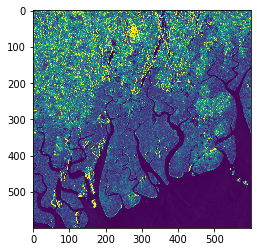

In [5]:
plt.imshow(bands[0])

# Despeckle

In [6]:
def fwd(img):
    return 10 * np.log10(img)

def bwd(img):
    return 10**(img / 10)

def tv_denoise(img, weight):
    img_db = fwd(img)
    img_db_tv = denoise_tv_bregman(img_db, weight)
    img_tv = bwd(img_db_tv)
    return img_tv

def tv_partial(band):
    return tv_denoise(band, .5)

In [7]:
bands_tv = list(map(tv_partial, bands))

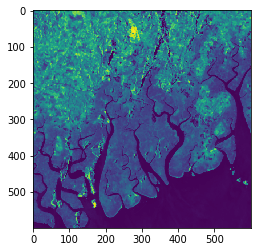

In [8]:
plt.imshow(bands_tv[0])

## Write despeckles images

In [9]:
hv_0 = bands_tv[1]
hv_1 = bands_tv[3]
hh_0 = bands_tv[0]
hh_1 = bands_tv[2]

diff_hv = hv_1 - hv_0
diff_hh = hh_1 - hh_0

In [10]:
p = profile.copy()
p['count'] = 1
with rasterio.open('hv_0.tif', 'w', **p) as ds:
    ds.write(hv_0, 1)
with rasterio.open('hv_1.tif', 'w', **p) as ds:
    ds.write(hv_1, 1)
    
with rasterio.open('hh_0.tif', 'w', **p) as ds:
    ds.write(hh_0, 1)
with rasterio.open('hh_1.tif', 'w', **p) as ds:
    ds.write(hh_1, 1)

## Visualize

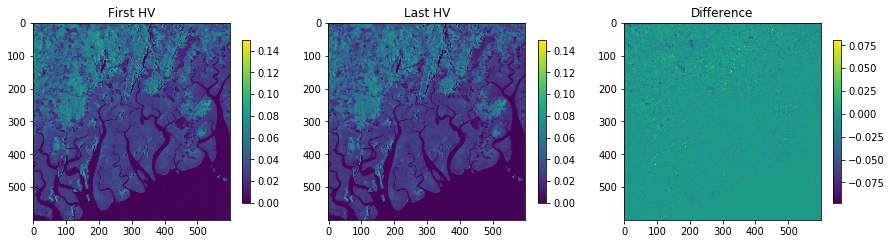

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

im = ax[0].imshow(hv_0, vmax=.15)
ax[0].set_title('First HV')
fig.colorbar(im, ax=ax[0], shrink=.3)


im = ax[1].imshow(hv_1, vmax=.15)
ax[1].set_title('Last HV')
fig.colorbar(im, ax=ax[1], shrink=.3)

ax[2].set_title('Difference')
im = ax[2].imshow(diff_hv)
fig.colorbar(im, ax=ax[2], shrink=.3)

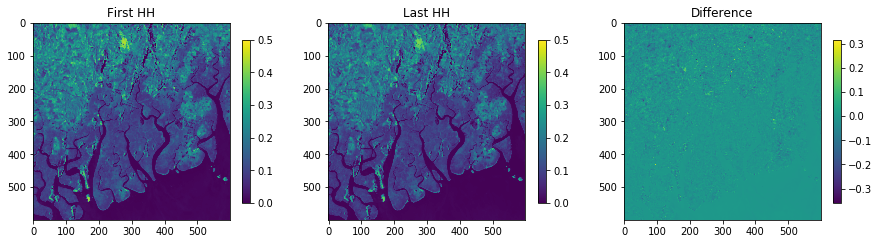

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

im = ax[0].imshow(hh_0, vmax=.5)
ax[0].set_title('First HH')
fig.colorbar(im, ax=ax[0], shrink=.3)


im = ax[1].imshow(hh_1, vmax=.5)
ax[1].set_title('Last HH')
fig.colorbar(im, ax=ax[1], shrink=.3)

ax[2].set_title('Difference')
im = ax[2].imshow(diff_hh)
fig.colorbar(im, ax=ax[2], shrink=.3)

## Select a threshold for the HV Difference

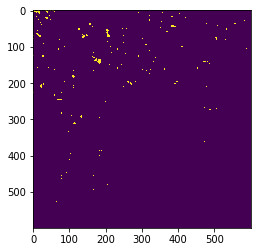

In [13]:
change_class = (diff_hv < -.025).astype(int)
plt.imshow(change_class)

We can experiment with a range of thresholds between `-0.05` and `-0.01`.

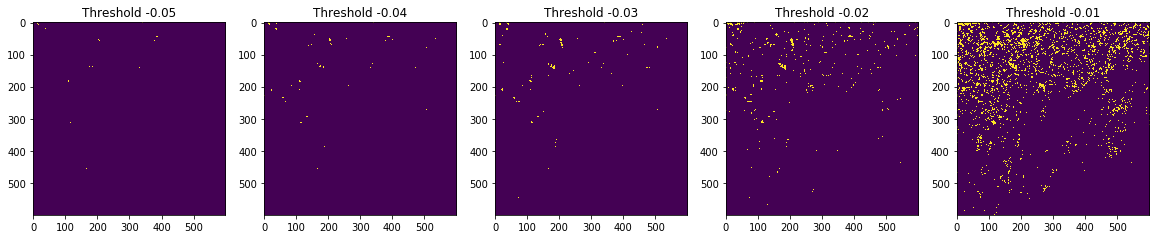

In [14]:
thresholds = np.linspace(-.05, -.01,5)
N = len(thresholds)
fig, ax = plt.subplots(1, N, figsize=(20, 10))
for (ax, t) in zip(ax.ravel(), thresholds):
    ax.imshow((diff_hv < t).astype(int))
    ax.set_title(f'Threshold {t:1.2f}')

## Morphological Filtering

We see there are lots of small areas where we detected change. This could be the residual noise in the image or just small environmental changes such as a truck traveling down a previously empty road.

We can filter an change areas by size. Specifically, we segment a binary array into contiguous parts using [`label`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html#scipy.ndimage.measurements.label) and then measure each segments size. Using these labels and size, we only consider change areas of a specific size.

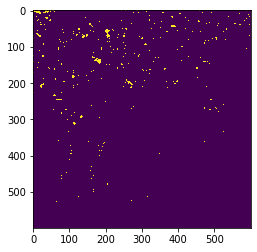

In [15]:
change_class = (diff_hv < -.02).astype(int)
plt.imshow(change_class)

Below, we filter those areas that are less than 25 pixels.

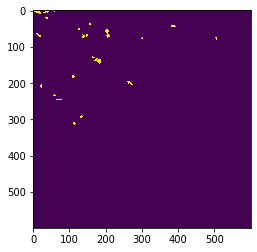

In [16]:
change_class_filtered = filter_binary_array_by_min_size(change_class, 25)

plt.imshow(change_class_filtered)

In [17]:
polygonize_array_to_shapefile(change_class_filtered, 
                              profile, 
                              'changes_hv_decrease', 
                              mask=~(change_class_filtered.astype(bool)))

# Using Superpixels

We may wish to use superpixels rather than morphological filtering to ensure large enough change areas are registered from the outset. In fact, superpixels can track areas through an entire time series of images as in our [paper](https://www.mdpi.com/2072-4292/11/5/556).

Let's segment according to the first and last HV image.

In [18]:
superpixel_labels = felzenszwalb(np.stack([hv_0, hv_1], axis=2), 
                                 scale=.5, 
                                 sigma=0, 
                                 min_size=15, 
                                 multichannel=True)

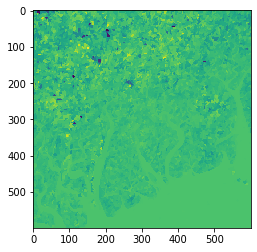

In [19]:
mean_features = get_superpixel_means_as_features(superpixel_labels, diff_hv)
mean_array = get_array_from_features(superpixel_labels, mean_features)
plt.imshow(mean_array)

# Exercise 1 - Using K-Means for Change Detection

Use k-means to determine the change threshold using the superpixels found above and save to a shapefile.

In [20]:
## Answer

In [21]:
## Answer

In [22]:
## Answer

In [23]:
## Answer

In [24]:
## Answer

One could easily identify the class with greates hv loss to remove the dependence of the above approach on the user.


# Analyzing Statistics Between Our Pair

We have the following statistics we can inspect by hand:

1. HV from the first image
2. HV from the last image
3. HH from the first image
4. HH from the last image

We can visualize the statistics of the above quanties with respect to our labeled areas. Maybe there are interesting relationships of scattering that we can more easily see with the [pair plot](https://seaborn.pydata.org/examples/scatterplot_matrix.html).

To do this, we have to create a [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) dataframe, which you should think of as a spreadsheet stored in python.

In [25]:
mean_features_hv_0 = get_superpixel_means_as_features(superpixel_labels, hv_0)
mean_features_hv_1 = get_superpixel_means_as_features(superpixel_labels, hv_1)
mean_features_hh_0 = get_superpixel_means_as_features(superpixel_labels, hh_0)
mean_features_hh_1 = get_superpixel_means_as_features(superpixel_labels, hh_1)

In [26]:
df = pd.DataFrame({'HH_0': mean_features_hh_0.ravel(),
                   'HH_1': mean_features_hh_1.ravel(),
                   'HV_0': mean_features_hv_0.ravel(),
                   'HV_1': mean_features_hv_1.ravel(),
                   'changes': (class_features==2).ravel(),
                  })
df.head()

,HH_0,HH_1,HV_0,HV_1,changes
0,0.194762,0.154122,0.061739,0.044976,False
1,0.207661,0.106981,0.074216,0.027814,True
2,0.224095,0.203775,0.047337,0.033440,False
3,0.197110,0.137660,0.039180,0.023662,False
4,0.224627,0.175124,0.053187,0.036412,False


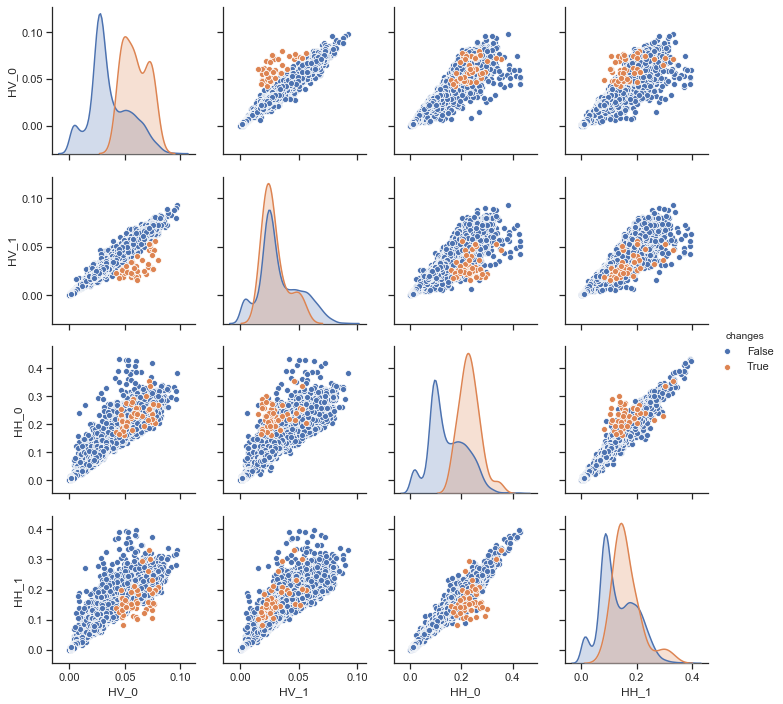

In [27]:
sns.set(style="ticks")

sns.pairplot(df, 
             vars=['HV_0', 'HV_1', 'HH_0', 'HH_1'], 
             hue="changes")

# Note

Now that you have your changed areas as shapefiles you can view them in [Google Earth Pro](https://www.google.com/earth/versions/) and use the time lapse functionality (demonstrated [here](https://www.youtube.com/watch?v=fxJe03ubfbw)) to validate these areas using very high resolution imagery.

# Appendix - RGB Composites and Mapping Mangroves with HH

Suppose you have a region that you want to identify mangroves using SAR. Let's do this using the ASF data.

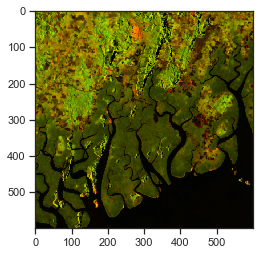

In [28]:
rgb_temp = bands_tv[:2] + [bands_tv[0] / (bands_tv[1] + .00001)]
rgb_temp = list(map(scale_img, rgb_temp))
rgb_0 = scale_img(np.stack(rgb_temp, axis=2))

plt.imshow(rgb_0)

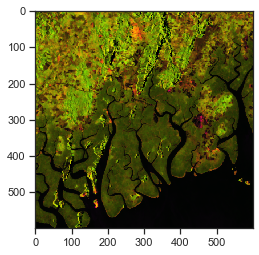

In [29]:
rgb_temp = bands_tv[2:] + [bands_tv[2] / (bands_tv[3] + .001)]
rgb_temp = list(map(scale_img, rgb_temp))
rgb_1 = np.stack(rgb_temp, axis=2)

plt.imshow(rgb_1)

In [30]:
p = profile.copy()
p['count'] = 3
p['dtype'] = 'float32'
p['nodata']= np.nan
with rasterio.open('rgb_0.tif', 'w', **p) as ds:
    ds.write(rgb_0.transpose([2, 0, 1]))

with rasterio.open('rgb_1.tif', 'w', **p) as ds:
    ds.write(rgb_1.transpose([2, 0, 1]))

Let's classify the first image using just HH.

In [31]:
superpixel_labels = felzenszwalb(hh_1, 
                                 scale=.5, 
                                 sigma=0, 
                                 min_size=15, 
                                 multichannel=True)

We'll use the standard deviation too.

In [32]:
mean_features = get_superpixel_means_as_features(superpixel_labels, hh_1)
std_features = scale_img(get_superpixel_means_as_features(superpixel_labels, hh_1))

In [33]:
## Answer

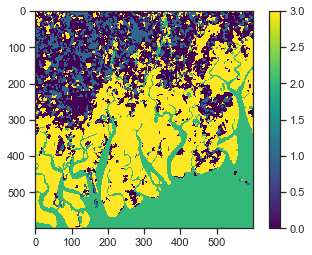

In [34]:
class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes, cmap='viridis')
plt.colorbar()

We definitely can see the mangrove areas and water correctly classified near the coast but there is some confusion as you go inland. You can Check the other areas using a basemap in QGIS with our HH layer. Since Mangroves are near the coast, you can always consider areas within some fixed distance to the coast as done [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html#scipy.ndimage.distance_transform_edt). You could also do some morphological filtering as we did earlier to remove small mangrove areas (false positives are those that are small in size).

We'll save the classes above as a tif.

In [35]:
p['count'] =1
p['dtype'] = 'uint8'
p['nodata'] = None
with rasterio.open('classes.tif', 'w', **p) as ds:
    ds.write(classes.astype('uint8'), 1)

For the mangrove areas, you may wish to compare [global mangrove watch](https://www.globalmangrovewatch.org/).

Remember, the model we used was k-means, one of the simplest algorithms. You can use any supervised or unsupervised classification algorithm in [sklearn](https://scikit-learn.org/stable/user_guide.html) or convolutional neural nets as done [here](https://github.com/nshaud/DeepNetsForEO).

# Acknowledgements

This tutorial was written by Charlie Marshak and supervised closely by [Marc Simard](https://scholar.google.com/citations?user=JQJF1wgAAAAJ&hl=en). 

This tutorial was for the 2019 SARI training [conference](http://sari.umd.edu/meetings/international-regional-science-training) held at Prince of Songkla University, Phuket Campus. We are grateful to the conference organizers (in particular [Krishna Vadrevu](https://geog.umd.edu/facultyprofile/vadrevu/krishna)), the [SARI program](http://sari.umd.edu/), and the [LCLUC program](https://lcluc.umd.edu/) working to make this training conference possible. We are grateful for the input from and helpful conversations with [Michael Denbina](https://www.researchgate.net/profile/Michael_Denbina), [Tien-Hao Liao](https://scienceandtechnology.jpl.nasa.gov/tien-hao-liao), and Neda Kasraee. 

We gratefully and humbly acknowledge JAXA for the use of ALOS-2 data to generate a coherence image over Mondah, Gabon generated using ISCE2. We are also grateful to the ASF for providing easy access to ALOS-1 radiometrically and terrain corrected tiles over Mondah and Ko Panyi.

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. 

Copyright 2019 by the California Institute of Technology. ALL RIGHTS RESERVED. United States Government Sponsorship acknowledged. Any commercial use must be negotiated with the Office of Technology Transfer at the California Institute of Technology.

This software may be subject to U.S. export control laws. By accepting this software, the user agrees to comply with all applicable U.S. export laws and regulations. User has the responsibility to obtain export licenses, or other export authority as may be required before exporting such information to foreign countries or providing access to foreign persons.
